In [1]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

In [2]:
# Carregar datasets
dataset = pd.read_csv('dataset.csv')
features = pd.read_csv('just_features.csv')

In [3]:
# Função para tratamento de outliers usando IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [4]:
# Remover outliers na variável 'custo' e 'imc'
dataset = remove_outliers(dataset, 'custo')
dataset = remove_outliers(dataset, 'imc')

In [5]:
# Separar features e target
X = dataset.drop(columns=['custo'])
y = dataset['custo']

In [6]:
# Identificar colunas categóricas e numéricas
categorical_features = ['genero', 'estado_civil', 'zona_residencia', 'fumador', 'class_etaria']
numerical_features = ['imc']

In [7]:
# Configurar transformadores
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

In [8]:
# Criar o preprocessador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline com SVR
svr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', SVR())
])

In [10]:
# Grid de parâmetros otimizado
param_grid_svr = {
    'regressor__C': [100, 500, 1000, 2000],
    'regressor__epsilon': [0.01, 0.05, 0.1],
    'regressor__kernel': ['rbf'],
    'regressor__gamma': ['scale', 0.01, 0.001]
}

In [11]:
grid_search_svr = GridSearchCV(svr_pipeline, param_grid_svr, cv=10, scoring='r2', verbose=2)


In [12]:
# Treinar SVR
print("Ajustando o modelo SVR...")
grid_search_svr.fit(X_train, y_train)

Ajustando o modelo SVR...
Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV] END regressor__C=100, regressor__epsilon=0.01, regressor__gamma=scale, regressor__kernel=rbf; total time=   0.0s
[CV] END regressor__C=100, regressor__epsilon=0.01, regressor__gamma=scale, regressor__kernel=rbf; total time=   0.0s
[CV] END regressor__C=100, regressor__epsilon=0.01, regressor__gamma=scale, regressor__kernel=rbf; total time=   0.0s
[CV] END regressor__C=100, regressor__epsilon=0.01, regressor__gamma=scale, regressor__kernel=rbf; total time=   0.0s
[CV] END regressor__C=100, regressor__epsilon=0.01, regressor__gamma=scale, regressor__kernel=rbf; total time=   0.0s
[CV] END regressor__C=100, regressor__epsilon=0.01, regressor__gamma=scale, regressor__kernel=rbf; total time=   0.0s
[CV] END regressor__C=100, regressor__epsilon=0.01, regressor__gamma=scale, regressor__kernel=rbf; total time=   0.0s
[CV] END regressor__C=100, regressor__epsilon=0.01, regressor__gamma=scale, regressor

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['imc']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['genero',
                                                                          'estado_civil',
                                                                          'zona_residencia',
                                                                          'fumador',
                                                                          'class_etaria'])])),
                                       ('regressor', SVR())]),
             param_grid={'regressor__C': [100, 500, 1000, 2000],
                         'regressor__epsilon': [0.01, 0.05, 0.1],
                         'regressor__gamma': ['scale', 0.01, 0.001],
                         'regressor__kernel': ['rbf']},
             scoring='r2', verbose=2)

In [13]:
best_svr = grid_search_svr.best_estimator_
print(f"Melhores hiperparâmetros SVR: {grid_search_svr.best_params_}")

Melhores hiperparâmetros SVR: {'regressor__C': 2000, 'regressor__epsilon': 0.1, 'regressor__gamma': 'scale', 'regressor__kernel': 'rbf'}


In [14]:
# Avaliação do modelo SVR
y_pred_svr = best_svr.predict(X_test)
score_svr = r2_score(y_test, y_pred_svr)
print(f"R² Score com SVR ajustado: {score_svr:.4f}")

R² Score com SVR ajustado: 0.5550


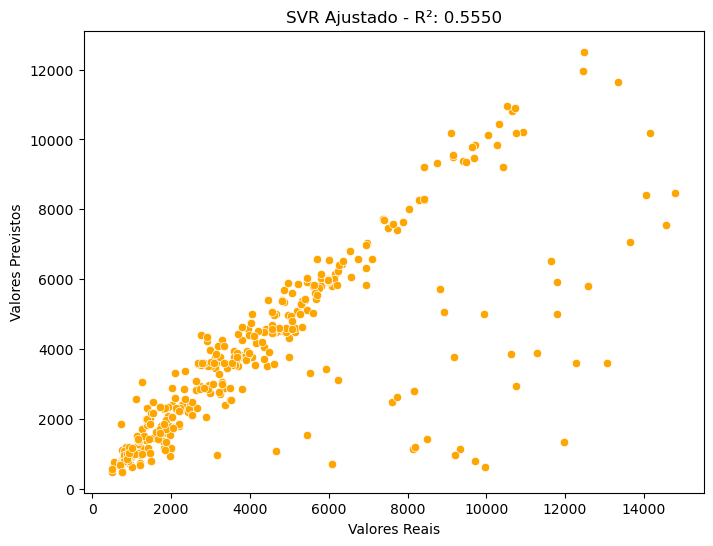

In [15]:
# Gráfico comparando valores reais e previstos
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_svr, color='orange')
plt.xlabel("Valores Reais")
plt.ylabel("Valores Previstos")
plt.title(f"SVR Ajustado - R²: {score_svr:.4f}")
plt.show()

In [16]:
# Previsão para novos dados (just_features.csv)
predictions = best_svr.predict(features)
predictions_df = pd.DataFrame(predictions, columns=['custo'])
predictions_df.to_csv('grupo#_custos_estimados.csv', index=False)
print("Predições salvas no arquivo 'grupo#_custos_estimados.csv'")

Predições salvas no arquivo 'grupo#_custos_estimados.csv'
